In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# sharp plots with higher resolution
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

In [2]:
# data set generation
n_1 = 1000
class_1 = np.random.beta([2, 1], [1, 4], size=(n_1, 2))
class_2 = np.random.beta([2, 1], [1, 1], size=(n_1, 2))
class_1[:, 0] = class_1[:, 0] * 0.4
class_2[:, 0] = class_2[:, 0] * -0.4 +1

labels_1 = np.zeros((n_1, 1))
labels_2 = np.ones((n_1, 1))


class_1 = np.hstack([class_1, labels_1])
class_2 = np.hstack([class_2, labels_2])

data_set_beta_hm_l = np.vstack([class_1, class_2])
np.random.shuffle(data_set_beta_hm_l)
# in theory here we should save the dataset  :)

In [3]:
def gaussian_generator(center, eig_val, eig_vec, size):
    sigma = np.matmul(np.matmul(eig_vec, eig_val), np.transpose(eig_vec))
    data_set = np.random.multivariate_normal(center, sigma, size)

    return data_set

In [4]:
# alternative data set 
n_1 = 1000  # number of the elements
mu_1 = np.array([0, 0])  # center (centroid)

# sigma is expected to be positive  semi-definite matrix
w_1 = np.array([[1.5, 0], [0, 4.5]])  # eigenvalues
v_1 = np.array([[0.4, 0], [0, 0.4]])  # eigenvectors

set_1 = gaussian_generator(mu_1,w_1, v_1, n_1)

set_1_1 = set_1[set_1[:, 0] > 0.5, :]
set_1_2 = set_1[set_1[:, 0] < 0.5, :]

set_1_3 = set_1_1[set_1_1[:, 1] < -0.5, :]
set_1_1 = set_1_1[set_1_1[:, 1] > -0.5, :]
set_1_4 = set_1_2[set_1_2[:, 1] < -0.5, :]
set_1_2= set_1_2[set_1_2[:, 1] > -0.5, :]

set_2_1 = set_1_1
set_2_2 = set_1_2
set_2_3 = set_1_3
set_2_4 = set_1_4

set_2_1 = set_2_1
set_2_2[:, 0] = set_2_2[:, 0] - 0.1
set_2_2[:, 1] = set_2_2[:, 1] + 0.1
set_2_4 = set_2_4
set_2_3[:, 0] = set_2_3[:, 0]
set_2_3[:, 1] = set_2_3[:, 1]

class_9 = set_2_2
class_10 = np.vstack([set_2_1, set_2_3, set_2_4])

labels_9 = np.zeros((len(class_9), 1))
labels_10 = np.ones((len(class_10), 1))

class_9 = np.hstack([class_9, labels_9])
class_10 = np.hstack([class_10, labels_10])

data_set_norm_hm_sq = np.vstack([class_9, class_10])
np.random.shuffle(data_set_norm_hm_sq)

data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 0] < 2, :]
data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 0] > -2, :]

data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 1] < 2, :]
data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 1] > -2, :]

In [5]:
data_set_beta_hm_l = data_set_norm_hm_sq
X0 = data_set_beta_hm_l[:, 0:2]
y0 = data_set_beta_hm_l[:, 2]

X, y = X0.copy(), y0.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

In [6]:
clf_lk = SVC(kernel='linear', probability=True)
clf_lk.fit(X_train, y_train)
y_hat = clf_lk.predict(X_test)
clf_lk.score(X_test,y_test) # the data are nicely linearly separable -> perfect accuracy

0.923469387755102

In [7]:
# function that helps to plot the decision boundary
def plot_SVCclassification(sig1,sig2,clf,xmax,ymax,lgd):
    grid=20
    xx,yy = np.meshgrid(np.linspace(0, xmax, grid),np.linspace(0, ymax, grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = clf.decision_function(X_).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.8,colors=['#f2f6ff','#faf2f6'])
    plt.contour(cs, colors='k')
    
    s1 = plt.scatter(sig1[:,0], sig1[:,1], color='#3829a3', edgecolors='k', linewidths=0.4)
    s2 = plt.scatter(sig2[:,0], sig2[:,1], color='#e1177e', edgecolors='k', linewidths=0.4)
    plt.xlabel('Hard margin', fontsize=12)
    plt.ylabel('Soft margin', fontsize=12)
    plt.legend([s1,s2], [lgd[0],lgd[1]], bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2)

In [8]:
X_testF = X_test[y_test == 0]
X_testF2 = X_test[y_test == 1]

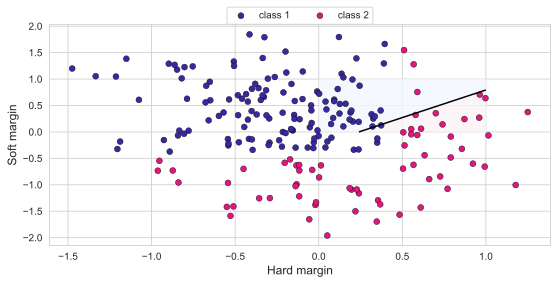

In [9]:
fig = plt.figure(figsize=(9, 4))
plot_SVCclassification(X_testF,X_testF2,clf_lk,1,1,['class 1', 'class 2'])
plt.show()

In [10]:
# LIME explainer for two features and two classes
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=["feat1","feat2"],
                                                  class_names=["class1","class2"], mode='classification')

In [11]:
# Choose the 1st instance (2nd element) and use it to predict the results
j = 1
exp = explainer.explain_instance(data_row=X_test[j], predict_fn=clf_lk.predict_proba)

print(X_test[j])
print(exp.as_list())
print(exp.as_list()[0][1])

[0.0862444  0.26341671]
[('0.12 < feat2 <= 0.61', -0.25349203537651194), ('-0.05 < feat1 <= 0.28', 0.03763442763345781)]
-0.25349203537651194


In [42]:
n_test = len(X_test)
exp_weights = np.zeros((n_test, 2))
for i in range(0, n_test):
    exp = explainer.explain_instance(data_row=X_test[i, :], predict_fn=clf_lk.predict_proba)
    exp_weights[i, 0] = exp.as_list()[0][1] # abs is not good just a temp fix
    exp_weights[i, 1] = exp.as_list()[1][1]


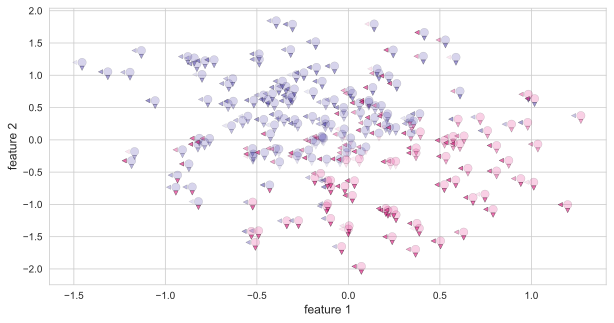

In [47]:
X_test_hat_1 = X_test[y_hat == 0]
X_test_hat_2 = X_test[y_hat == 1]

y_test_1 = y_test[y_hat == 0]
y_test_2 = y_test[y_hat == 1]

exp_weights_1 = exp_weights[y_hat == 0]
exp_weights_2 = exp_weights[y_hat == 1]

X_test_exp_11 = X_test[exp_weights[:, 0] > 0]
X_test_exp_12 = X_test[exp_weights[:, 0] < 0]

exp_weights_11 = exp_weights[exp_weights[:, 0] > 0]
exp_weights_12 = exp_weights[exp_weights[:, 0] < 0]


X_test_exp_21 = X_test[exp_weights[:, 1] > 0]
X_test_exp_22 = X_test[exp_weights[:, 1] < 0]

exp_weights_21 = exp_weights[exp_weights[:, 1] > 0]
exp_weights_22 = exp_weights[exp_weights[:, 1] < 0]


fig = plt.figure(figsize=(10, 5))

cdict = { 0: 'blue',  1: 'red'}

# plot true and predicted classes
s_01 = plt.scatter(X_test_hat_1[:,0] + 0.02, X_test_hat_1[:,1], s=70, color='#3829a3', edgecolors='k', linewidths=0.4, alpha=0.2)
s_02 = plt.scatter(X_test_hat_2[:,0] + 0.02, X_test_hat_2[:,1], s=70, color='#e1177e', edgecolors='k', linewidths=0.4, alpha=0.2)

#strength of the first feature

s_03 = plt.scatter(X_test_exp_11[:, 0] + 0.02, X_test_exp_11[:, 1] -0.09,  s=20, color='#e1177e', edgecolors='k', linewidths=0.4, alpha=exp_weights_11[:, 0], marker="v")

s_04 = plt.scatter(X_test_exp_12[:, 0] + 0.02, X_test_exp_12[:, 1] - 0.09,  s=20, color='#3829a3', edgecolors='k', linewidths=0.4, alpha=np.abs(exp_weights_12[:, 0]), marker="v")

s_05 = plt.scatter(X_test_exp_21[:, 0] - 0.02, X_test_exp_21[:, 1] ,  s=20, color='#e1177e', edgecolors='k', linewidths=0.4, alpha=exp_weights_11[:, 0], marker="<")

s_06 = plt.scatter(X_test_exp_22[:, 0] -0.02, X_test_exp_22[:, 1] ,  s=20, color='#3829a3', edgecolors='k', linewidths=0.4, alpha=np.abs(exp_weights_12[:, 0]), marker="<")


#s1 = plt.scatter(X_test_hat_1[:,0], X_test_hat_1[:,1], s=20, color='#3829a3', edgecolors='k', linewidths=0.4, alpha=exp_weights_1[:, 0], marker="<")
#s2 = plt.scatter(X_test_hat_2[:,0],X_test_hat_2[:,1], s=20, color='#e1177e', edgecolors='k', linewidths=0.4, alpha= exp_weights_2[:, 0], marker="<")

#strength of the second feature 
#s3 = plt.scatter(X_test_hat_1[:,0]+0.04, X_test_hat_1[:,1], s=20, color='#3829a3', edgecolors='k', linewidths=0.4, alpha=exp_weights_1[:, 1], marker=">")
#s4 = plt.scatter(X_test_hat_2[:,0]+0.04,X_test_hat_2[:,1], s=20, color='#e1177e', edgecolors='k', linewidths=0.4, alpha= exp_weights_2[:, 1], marker=">")

plt.xlabel('feature 1', fontsize=12)
plt.ylabel('feature 2', fontsize=12)
#plt.legend([s1,s2], ['class 1', 'class 2'])
plt.show()